<a href="https://colab.research.google.com/github/Algon-33/TWI-Generation/blob/main/TWI%20Class%20Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import random
%matplotlib inline

ModuleNotFoundError: ignored

In [2]:
# download the names.txt file from github
#!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
#!wget https://raw.githubusercontent.com/Algon-33/TWI-Generation/main/classes_cleaned.txt
#!wget https://raw.githubusercontent.com/Algon-33/TWI-Generation/main/skills.txt
#!wget https://raw.githubusercontent.com/Algon-33/TWI-Generation/main/spells.txt
!wget https://raw.githubusercontent.com/Algon-33/TWI-Generation/main/dataset.txt

--2022-10-26 22:13:48--  https://raw.githubusercontent.com/Algon-33/TWI-Generation/main/dataset.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104606 (102K) [text/plain]
Saving to: ‘dataset.txt’

dataset.txt         100%[===================>] 102.15K  --.-KB/s    in 0.002s  

2022-10-26 22:13:49 (48.3 MB/s) - ‘dataset.txt’ saved [104606/104606]



In [3]:
from re import S
# read in all the words
random.seed(925)
words = open('dataset.txt', 'r').read().splitlines()
words = list(map( lambda x: x.strip("]").strip("["), words))
random.shuffle(words)
words[0:8]

['cafe manager',
 'ambush commander',
 'reckless charge',
 'riders',
 'renowned tincturist',
 'heavyweight punch',
 'arbiters',
 'fashionistas']

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['@'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: ' ', 2: '!', 3: "'", 4: '(', 5: ')', 6: ',', 7: '.', 8: '1', 9: '4', 10: '5', 11: ':', 12: '?', 13: '[', 14: ']', 15: '_', 16: 'a', 17: 'b', 18: 'c', 19: 'd', 20: 'e', 21: 'f', 22: 'g', 23: 'h', 24: 'i', 25: 'j', 26: 'k', 27: 'l', 28: 'm', 29: 'n', 30: 'o', 31: 'p', 32: 'q', 33: 'r', 34: 's', 35: 't', 36: 'u', 37: 'v', 38: 'w', 39: 'x', 40: 'y', 41: 'z', 42: '’', 43: '…', 0: '@'}
44


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '@':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([73798, 3]) torch.Size([73798])
torch.Size([9272, 3]) torch.Size([9272])
torch.Size([9110, 3]) torch.Size([9110])


In [64]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

15684


In [75]:
Xdev

tensor([[ 0,  0,  0],
        [ 0,  0, 24],
        [ 0, 24, 18],
        ...,
        [20, 28, 31],
        [28, 31, 35],
        [31, 35, 34]])

In [87]:
, X
# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []
loss_dev_old = 100
for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 1000 == 0: # print every once in a while
    with torch.no_grad():
      emb_dev = C[Xdev]
      embcat_dev = emb_dev.view(emb_dev.shape[0], -1) # concatenate the vectors
      # Linear layer
      hpreact_dev = embcat_dev @ W1 #+ b1 # hidden layer pre-activation
      # BatchNorm layer
      # -------------------------------------------------------------
      bnmeani_dev = hpreact_dev.mean(0, keepdim=True)
      bnstdi_dev = hpreact_dev.std(0, keepdim=True)
      hpreact_dev = bngain * (hpreact_dev - bnmeani_dev) / bnstdi_dev + bnbias
      # -------------------------------------------------------------
      # Non-linearity
      h_dev = torch.tanh(hpreact_dev) # hidden layer
      logits_dev = h_dev @ W2 + b2 # output layer
      loss_dev_new = F.cross_entropy(logits_dev, Ydev) # loss function
      if ((loss_dev_new-loss_dev_old)/loss_dev_new)**2<0.0000001:
        break
      else:
        loss_dev_old = loss_dev_new

    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

      0/  20000: 1.8569
   1000/  20000: 1.9727
   2000/  20000: 1.9473
   3000/  20000: 1.3993
   4000/  20000: 1.9784
   5000/  20000: 1.7915
   6000/  20000: 2.0031
   7000/  20000: 1.7514
   8000/  20000: 1.9104
   9000/  20000: 1.5560
  10000/  20000: 1.6429
  11000/  20000: 2.0409
  12000/  20000: 2.0253
  13000/  20000: 2.1243
  14000/  20000: 2.2252


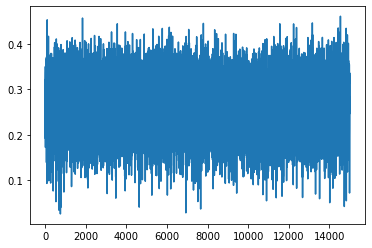

In [88]:
plt.plot(lossi)

In [89]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)


In [90]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7613108158111572
val 1.9592565298080444


## loss log

### original:
train 2.1245384216308594
val   2.168196439743042

### fix softmax confidently wrong:
train 2.07
val   2.13

### fix tanh layer too saturated at init:
train 2.0355966091156006
val   2.1026785373687744

### use semi-principled "kaiming init" instead of hacky init:
train 2.0376641750335693
val   2.106989622116089

### add batch norm layer
train 2.0668270587921143
val 2.104844808578491


In [12]:
# SUMMARY + PYTORCHIFYING -----------

In [62]:
Xtr[0:10]

tensor([[ 0,  0,  0],
        [ 0,  0, 22],
        [ 0, 22, 30],
        [22, 30, 33],
        [30, 33, 22],
        [33, 22, 20],
        [22, 20, 27],
        [20, 27, 20],
        [27, 20, 16],
        [20, 16, 31]])

In [107]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

18328


In [111]:
# same optimization as last time
max_steps = 30000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 15000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 1000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

#  if i >= 10000:
#    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/  30000: 2.9632
   1000/  30000: 3.1584
   2000/  30000: 2.8699
   3000/  30000: 2.9406
   4000/  30000: 2.8915
   5000/  30000: 2.9553
   6000/  30000: 3.0190
   7000/  30000: 2.9024
   8000/  30000: 2.8799
   9000/  30000: 2.5801
  10000/  30000: 2.6708
  11000/  30000: 2.8914
  12000/  30000: 2.9607
  13000/  30000: 2.5502
  14000/  30000: 2.6869
  15000/  30000: 2.7691
  16000/  30000: 2.6536
  17000/  30000: 2.5645
  18000/  30000: 2.6208
  19000/  30000: 2.6021
  20000/  30000: 2.6630
  21000/  30000: 2.5645
  22000/  30000: 2.5743
  23000/  30000: 2.5944
  24000/  30000: 2.5731
  25000/  30000: 2.6563
  26000/  30000: 2.9957
  27000/  30000: 2.6382
  28000/  30000: 2.8022
  29000/  30000: 2.5003


layer 2 (      Tanh): mean -0.00, std 0.10, saturated: 0.00%
layer 5 (      Tanh): mean -0.00, std 0.10, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

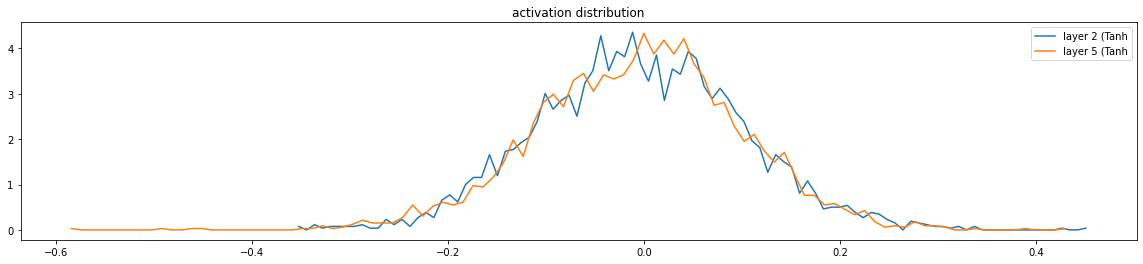

In [112]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

In [95]:
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print(t)

tensor([[ 1.3824e-03,  1.5281e-03, -3.1783e-03,  ...,  1.2181e-03,
         -6.1466e-04,  3.1799e-03],
        [-1.6698e-03, -5.6713e-03,  5.5955e-03,  ...,  4.8794e-05,
         -7.4165e-03,  4.4688e-03],
        [ 2.7959e-03,  7.6794e-04, -6.8459e-03,  ...,  2.8487e-03,
         -9.0766e-04,  3.5977e-03],
        ...,
        [-2.3035e-03,  7.5156e-04, -1.6972e-03,  ..., -4.8013e-03,
          7.2532e-04,  2.5901e-03],
        [-1.9922e-03, -2.7865e-03,  4.3913e-03,  ...,  4.6869e-04,
          8.5170e-03,  7.6892e-04],
        [ 1.0685e-02,  1.3851e-03, -6.7890e-04,  ..., -2.7758e-03,
          1.8474e-03, -7.1317e-03]])
tensor([[ 3.7321e-03,  1.5615e-03, -6.2705e-03,  ..., -2.2858e-03,
          2.2138e-03,  2.7299e-03],
        [ 3.6080e-03, -2.4029e-03,  4.7367e-03,  ..., -2.0009e-03,
          6.6021e-04, -8.0293e-04],
        [-3.3224e-03, -1.4623e-03,  6.0080e-03,  ...,  7.8795e-04,
         -4.0002e-03, -4.0775e-03],
        ...,
        [-1.3778e-03,  1.0832e-03, -6.8829e-03

layer 2 (      Tanh): mean -0.000000, std 4.249650e-03
layer 5 (      Tanh): mean -0.000000, std 4.380565e-03
layer 8 (      Tanh): mean -0.000000, std 4.500784e-03
layer 11 (      Tanh): mean -0.000000, std 4.449452e-03
layer 14 (      Tanh): mean +0.000000, std 4.146504e-03


Text(0.5, 1.0, 'gradient distribution')

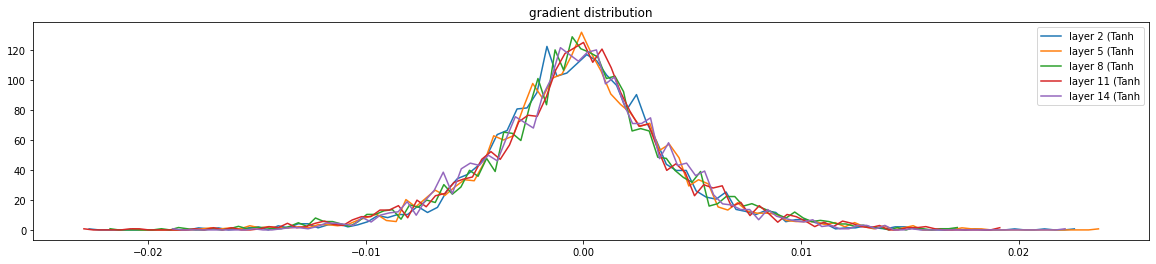

In [96]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (44, 10) | mean +0.000000 | std 1.244301e-02 | grad:data ratio 1.248448e-02
weight  (30, 100) | mean -0.000435 | std 1.315273e-02 | grad:data ratio 4.820806e-02
weight (100, 100) | mean -0.000047 | std 9.099237e-03 | grad:data ratio 5.487243e-02
weight (100, 100) | mean -0.000140 | std 9.556308e-03 | grad:data ratio 5.891238e-02
weight (100, 100) | mean -0.000076 | std 9.605983e-03 | grad:data ratio 6.076972e-02
weight (100, 100) | mean -0.000056 | std 8.926910e-03 | grad:data ratio 5.953401e-02
weight  (100, 44) | mean +0.000067 | std 1.139160e-02 | grad:data ratio 6.186265e-02


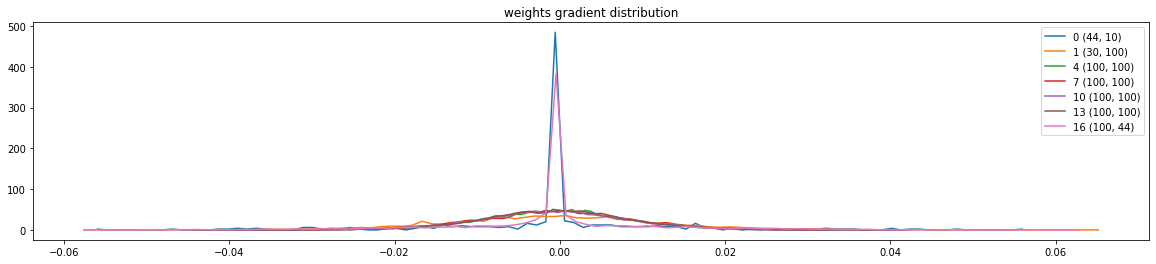

In [97]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

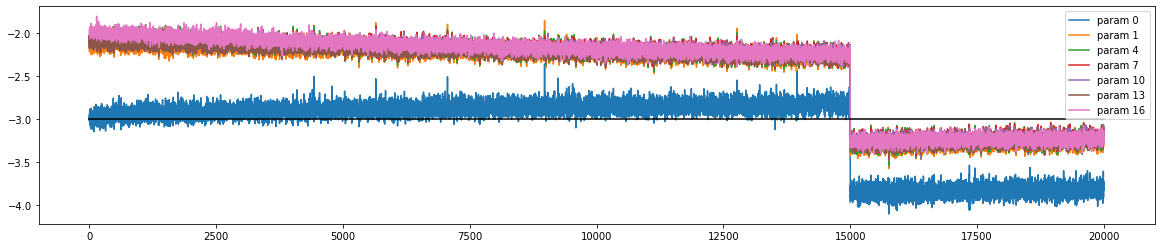

In [98]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [113]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.635573148727417
val 2.652531623840332


In [114]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(200):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

'ef@
orz f_a_'njthaf!or]y) h…ear,ohjels@
mj(i.' re pa5e pll@
,ecthe pna ta_m!!oman kg tur or nivemangj@
ar(_, as’s1!heange!o'4@
(k?sgrurrigatms@
[:u ylanu@
so_an ’gnene: ber!ayqin ]!ror@
4tef ’s oustrnk@
: suet5veol wainde@
5bkginy4r lird [iing kx yo4 spre ss]er corktr@
',!a’s …parq@
wrj_aslickme!., ths@
][]agchin?s:@
earq taz szeples@
maorseep4sapers@
hi1iti(gaka 1ngeat@
s5ew@
s!oar’ss@
]antercigphe: aves: parmane’s 15vendhennel ormaierlex@
’( _antint@
_efkart, ]:wa) ce,lm,ovembafi[hher@
sttveunprakverist@
!asera@
tmen[ef oen@
s]ange@
shurf oceas w5aj…?grewa!eme@
bi: s[uf muanmec' par… ]pan tonp)) f’s chel.@
dqu.@
:drvow@
daer surxnnginpperoa_le@
cfoj ze(ep@
sor nesf[ersrumpacep4nyws: sdler4ze’s (al’s ope oyte math.@
acbobacrvo5x@
) (_ek…aneoblediji u(trgen z@
'pity: @
ciettecvotir_en@
zep@
dco(m dor@
'@
mjasti…owceq shelsyf@
bavels@
furs@
ge?@
el@
ster@
were g'y ’s e.1narkaigy@
qo, (t_o@
rw@
smow(jeress@
za1ehtlimper@
s o’s rmauy@
te@
slunf iig[se(y flap,el !a1mathe,?@
@
'egn?shech.@

In [ ]:
# DONE; BONUS content below, not covered in video

In [21]:
# BatchNorm forward pass as a widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):
  
  g = torch.Generator().manual_seed(2147483647+1)
  x = torch.randn(5, generator=g) * 5
  x[0] = x0 # override the 0th example with the slider
  mu = x.mean()
  sig = x.std()
  y = (x - mu)/sig

  plt.figure(figsize=(10, 5))
  # plot 0
  plt.plot([-6,6], [0,0], 'k')
  # plot the mean and std
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
  # plot little lines connecting input and output
  for i in range(len(x)):
    plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
  # plot the input and output values
  plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
  plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
  plt.xlim(-6, 6)
  # title
  plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));


interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

In [22]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


In [23]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g) # / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())

inp std:  0.9875972270965576
w std:  1.0006722211837769
x std:  31.01241683959961
out std:  1.0
------
out grad std:  0.9782556295394897
x grad std:  0.031543977558612823
w grad std:  0.031169468536973
inp grad std:  0.9953053593635559
